In [1]:
import os
import json
import seaborn as sns
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from pyvis.network import Network
from matplotlib import colors

In [2]:
node_colors = {
    'SPD': 'red',
    'CDU': 'black',
    'AfD': 'blue',
    'FDP': 'yellow',
    'Bündnis 90/Die Grünen': 'green',
    'Die Linke': 'purple',
    'CSU': 'lightblue',
    'Fraktionslos': 'grey',
    'Nachrichtenportal': 'orange',
    'Virologe': 'maroon',
}

node_colors_hex = {
    'SPD': '#ff0000',
    'CDU': '#000000',
    'AfD': '#0000ff',
    'FDP': '#ffff00',
    'Bündnis 90/Die Grünen': '#00ff00',
    'Die Linke': '#800080',
    'CSU': '#add8e6',
    'Fraktionslos': '#777777',
    'Nachrichtenportal': '#ffa500',
    'Virologe': '#800000',
}

In [3]:
ALL_POLITICIANS_FILE = '../../assets/all_politicians.json'
NEWS_PORTALS_FILE = '../../assets/news_portals.json'
VIROLOGISTS_FILE = '../../assets/virologists.json'

with open(ALL_POLITICIANS_FILE, 'r', encoding='utf-8') as infile_all_politicians:
    all_politicians = json.load(infile_all_politicians)
with open(NEWS_PORTALS_FILE, 'r', encoding='utf-8') as infile_news_portals:
    news_portals = json.load(infile_news_portals)
with open(VIROLOGISTS_FILE, 'r', encoding='utf-8') as infile_virologists:
    virologists = json.load(infile_virologists)

additional_accounts = news_portals + virologists
all_accounts = all_politicians + additional_accounts

def get_acc_association(acc):
    if acc in all_politicians:
        return acc['Partei']
    else:
        return 'Nachrichtenportal' if acc in news_portals else 'Virologe'

# TODO: Add more attributes => number of (covid-)tweets, total followers
nodes = [(acc['id'], {
            'label': acc['Name'],
            'name': acc['Name'],
            'screen_name': acc['screen_name'],
            'association': get_acc_association(acc),
            'color': node_colors_hex[get_acc_association(acc)]
        }) for acc in all_accounts]

POLITICIANS_RELATIONS_FOLDER = '../formated_data/relationship_politicians'
ADDITIONAL_ACCOUNTS_RELATIONS_FOLDER = '../formated_data/relationship_additional_accounts'

edges = []

for p_rel_file in os.listdir(POLITICIANS_RELATIONS_FOLDER):
    curr_p_screen_name = os.path.splitext(p_rel_file)[0]
    curr_p_id = next((p['id'] for p in all_politicians if p['screen_name'] == curr_p_screen_name), None)
    with open(os.path.join(POLITICIANS_RELATIONS_FOLDER, p_rel_file), 'r', encoding='utf-8') as infile_curr_p_rels:
        curr_p_rels = json.load(infile_curr_p_rels)
        edges += [(curr_p_id, r['target_id']) for r in curr_p_rels if  r['value'] in (1, 2)]

for a_rel_file in os.listdir(ADDITIONAL_ACCOUNTS_RELATIONS_FOLDER):
    curr_a_screen_name = os.path.splitext(a_rel_file)[0]
    curr_a_id = next((a['id'] for a in additional_accounts if a['screen_name'] == curr_a_screen_name), None)
    with open(os.path.join(ADDITIONAL_ACCOUNTS_RELATIONS_FOLDER, a_rel_file), 'r', encoding='utf-8') as infile_curr_a_rels:
        curr_a_rels = json.load(infile_curr_a_rels)
        edges += [(curr_a_id, r['target_id']) for r in curr_a_rels if  r['value'] in (1, 2)]

In [4]:
G = nx.DiGraph()

G.add_nodes_from(nodes)
G.add_edges_from(edges)

degrees = [G.degree(n) for n in G.nodes]
min_degree, max_degree = min(degrees), max(degrees)
lower_limit, upper_limit = 10, 50
node_weight_map = [(G.degree(n) - min_degree) / (max_degree - min_degree) * (upper_limit - lower_limit) + lower_limit for n in G.nodes]

node_color_map = [G.nodes[nid]['color'] for nid in G.nodes]

def convert_color_to_rgba_dict(hex_color):
    rgba = colors.to_rgba(hex_color)
    return {'r': f'{int(rgba[0] * 255)}','g': f'{int(rgba[1] * 255)}', 'b': f'{int(rgba[2] * 255)}', 'a': f'{rgba[3]}'}

for i, n in enumerate(G.nodes):
    n_size = node_weight_map[i]
    G.add_node(n, viz={'color': convert_color_to_rgba_dict(node_color_map[i]), 'size': n_size})

# nx.write_gexf(G, 'followers_graph.gexf')

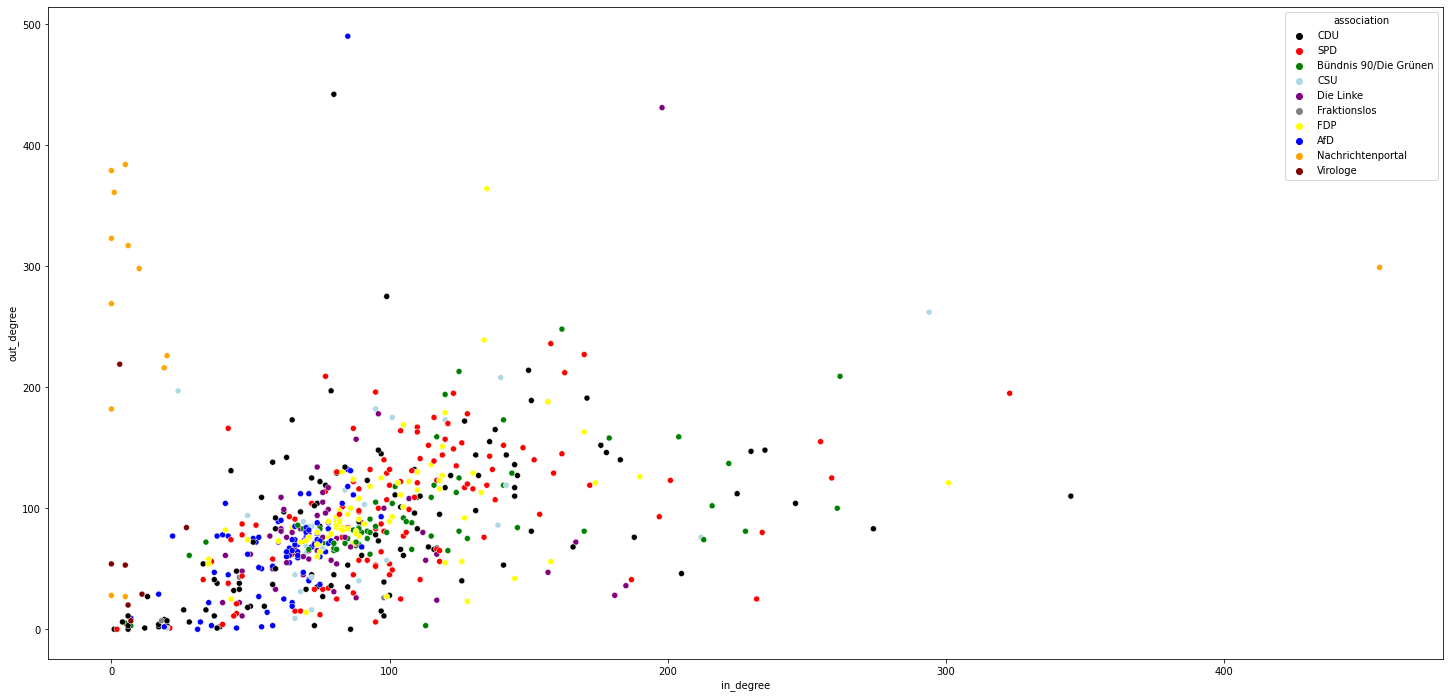

In [5]:
degree_dist = [{
    'node': n,
    'in_degree': G.in_degree(n),
    'out_degree': G.out_degree(n),
    'association': G.nodes[n]['association']
} for n in G.nodes]

df_degrees = pd.DataFrame(degree_dist)

fig = plt.figure(figsize=(25,12))
chart = sns.scatterplot(data=df_degrees,
                        x='in_degree',
                        y='out_degree',
                        hue='association',
                        palette=node_colors)
plt.show()

In [6]:
# fig = plt.figure(figsize=(25,12))
# fig_width, fig_height = fig.get_size_inches()
# fig_center = (fig_width * fig.dpi / 2, fig_height * fig.dpi / 2)

# pos = nx.spring_layout(G, k=0.5, weight=0.1, center=fig_center, seed=42)
# pos = nx.kamada_kawai_layout(G, weight=0.1, center=fig_center)

# nx.draw(G, pos, node_color=node_color_map, node_size=node_weight_map, edge_color='grey')

# plt.show()

In [7]:
from cdlib import algorithms, viz

In [8]:
nodes2 = [(i, {
            'label': acc['Name'],
            'name': acc['Name'],
            'screen_name': acc['screen_name'],
            'id': acc['id'],
            'association': get_acc_association(acc),
            'color': node_colors_hex[get_acc_association(acc)]
        }) for i, acc in enumerate(all_accounts)]

def get_node_id(screen_name):
    return next((n[0] for n in nodes2 if n[1]['screen_name'] == screen_name), None)

edges2 = []

for p_rel_file in os.listdir(POLITICIANS_RELATIONS_FOLDER):
    curr_p_screen_name = os.path.splitext(p_rel_file)[0]
    curr_p_node_id = get_node_id(curr_p_screen_name)
    with open(os.path.join(POLITICIANS_RELATIONS_FOLDER, p_rel_file), 'r', encoding='utf-8') as infile_curr_p_rels:
        curr_p_rels = json.load(infile_curr_p_rels)
        edges2 += [(curr_p_node_id, get_node_id(r['target_screen_name'])) for r in curr_p_rels if  r['value'] in (1, 2)]

for a_rel_file in os.listdir(ADDITIONAL_ACCOUNTS_RELATIONS_FOLDER):
    curr_a_screen_name = os.path.splitext(a_rel_file)[0]
    curr_a_node_id = get_node_id(curr_a_screen_name)
    with open(os.path.join(ADDITIONAL_ACCOUNTS_RELATIONS_FOLDER, a_rel_file), 'r', encoding='utf-8') as infile_curr_a_rels:
        curr_a_rels = json.load(infile_curr_a_rels)
        edges2 += [(curr_a_node_id, get_node_id(r['target_screen_name'])) for r in curr_a_rels if  r['value'] in (1, 2)]

In [9]:
G2 = nx.DiGraph()

G2.add_nodes_from(nodes2)
G2.add_edges_from(edges2)

node_color_map2 = [G2.nodes[nid]['color'] for nid in G2.nodes]

for i, n in enumerate(G2.nodes):
    G2.add_node(n, viz={'color': convert_color_to_rgba_dict(node_color_map2[i]), 'size': 20})

In [10]:
# can only be correctly installed and used under Linux
# coms = algorithms.infomap(G2)

# Drawing doesn't work, but algorithm itself does

In [11]:
from infomap import Infomap

def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    im = Infomap('--two-level --directed')

    print('Building network...')
    for e in G.edges:
        im.add_link(int(e[0]), int(e[1]))

    # Cluster network
    im.run()

    print(f'Found {im.num_top_modules} modules with codelength: {im.codelength}')

    communities = im.get_modules()
    nx.set_node_attributes(G, communities, 'community')
    nx.write_gexf(G, 'communities_graph_directed.gexf')


def draw_network(G):
    # position map
    pos = nx.spring_layout(G)
    # community index
    communities = [c - 1 for c in nx.get_node_attributes(G, 'community').values()]
    num_communities = max(communities) + 1

    # color map from http://colorbrewer2.org/
    cmap_light = colors.ListedColormap(
        ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', num_communities)
    cmap_dark = colors.ListedColormap(
        ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', num_communities)

    # edges
    nx.draw_networkx_edges(G, pos)

    # nodes
    node_collection = nx.draw_networkx_nodes(
        G, pos=pos, node_color=communities, cmap=cmap_light)

    # set node border color to the darker shade
    dark_colors = [cmap_dark(v) for v in communities]
    node_collection.set_edgecolor(dark_colors)

    # Print node labels separately instead
    # for n in G.nodes:
    #     plt.annotate(n,
    #                  xy=pos[n],
    #                  textcoords='offset points',
    #                  horizontalalignment='center',
    #                  verticalalignment='center',
    #                  xytext=[0, 2],
    #                  color=cmap_dark(communities[n]))

    plt.axis('off')
    plt.show()


findCommunities(G2)

# drawNetwork(G2)

Building network...
Found 15 modules with codelength: 8.135928922993655
